In [1]:
root_path = "data/"

In [2]:
# import modules
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
import tqdm.notebook as tq
import csv
import pickle # for saving results and loading them

# Functions

In [3]:
def DCSBMentropy(A, g):
  '''
  Input: 
    - adjacency matrix A of numpy sparse matrix type
    - g is a vector of partitions, integers
  Output:
    - h entropies np array
    - p value
  '''
  K = np.max(g) + 1
  e = np.zeros((K, K), dtype=np.double)
  for i in range(K):
    for j in range(K):
      e[i, j] = np.sum(A[g == i][:, g == j])
  m = np.sum(e, axis=1)
  e_sum = np.sum(m)
  for i in range(K):
    for j in range(K):
      e[i, j] /= m[i] * m[j]
  k = np.sum(A, axis=0)
  p = np.matmul(k.T, k) / e_sum
  p *= e[g][:, g]
  pp = np.triu(p)
  pp = pp[pp > 0]
  b = np.size(pp)
  h = 0.5 * ((b-1) * math.log(2 * math.pi * math.e * e_sum) + np.sum(np.log(pp)))
  return h, p

def BESTest(A, g, N = 10000):
  '''
  Input:
    - adjacency matrix A of numpy sparse matrix type
    - g is a vector of partitions, integers
    - N number of samples
  Output:
    - p-value
  '''
  h = np.zeros(shape = (N, ), dtype=np.double)
  h_partition, _ = DCSBMentropy(A,g);
  for i in range(N):
    permuted = np.copy(g)
    np.random.shuffle(permuted)
    h[i], _ = DCSBMentropy(A, permuted)
  p = np.sum(h <= h_partition) / N
  return p

def BESTest_confidence(A, g, N = 10000, n_conf = 30):
  pvals = np.array([BESTest(A, g, N) for _ in range(n_conf)])
  return np.mean(pvals), np.std(pvals)

def save_obj(obj, name ):
   with open(name + '.pkl', 'wb') as f:
       pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [4]:
# Load directed graph
g_directed = nx.read_graphml(root_path + "net_dir_with_attr.graphml")

# Undirected Network

## Create Matrix

In [5]:
# Create undirected graph with all the edges
# Create an adjacency matrix
g = g_directed.to_undirected()
print(g.number_of_nodes())
print(g.number_of_edges())
mat_g = nx.adjacency_matrix(g)
polit = mat_g.todense()

1207
37863


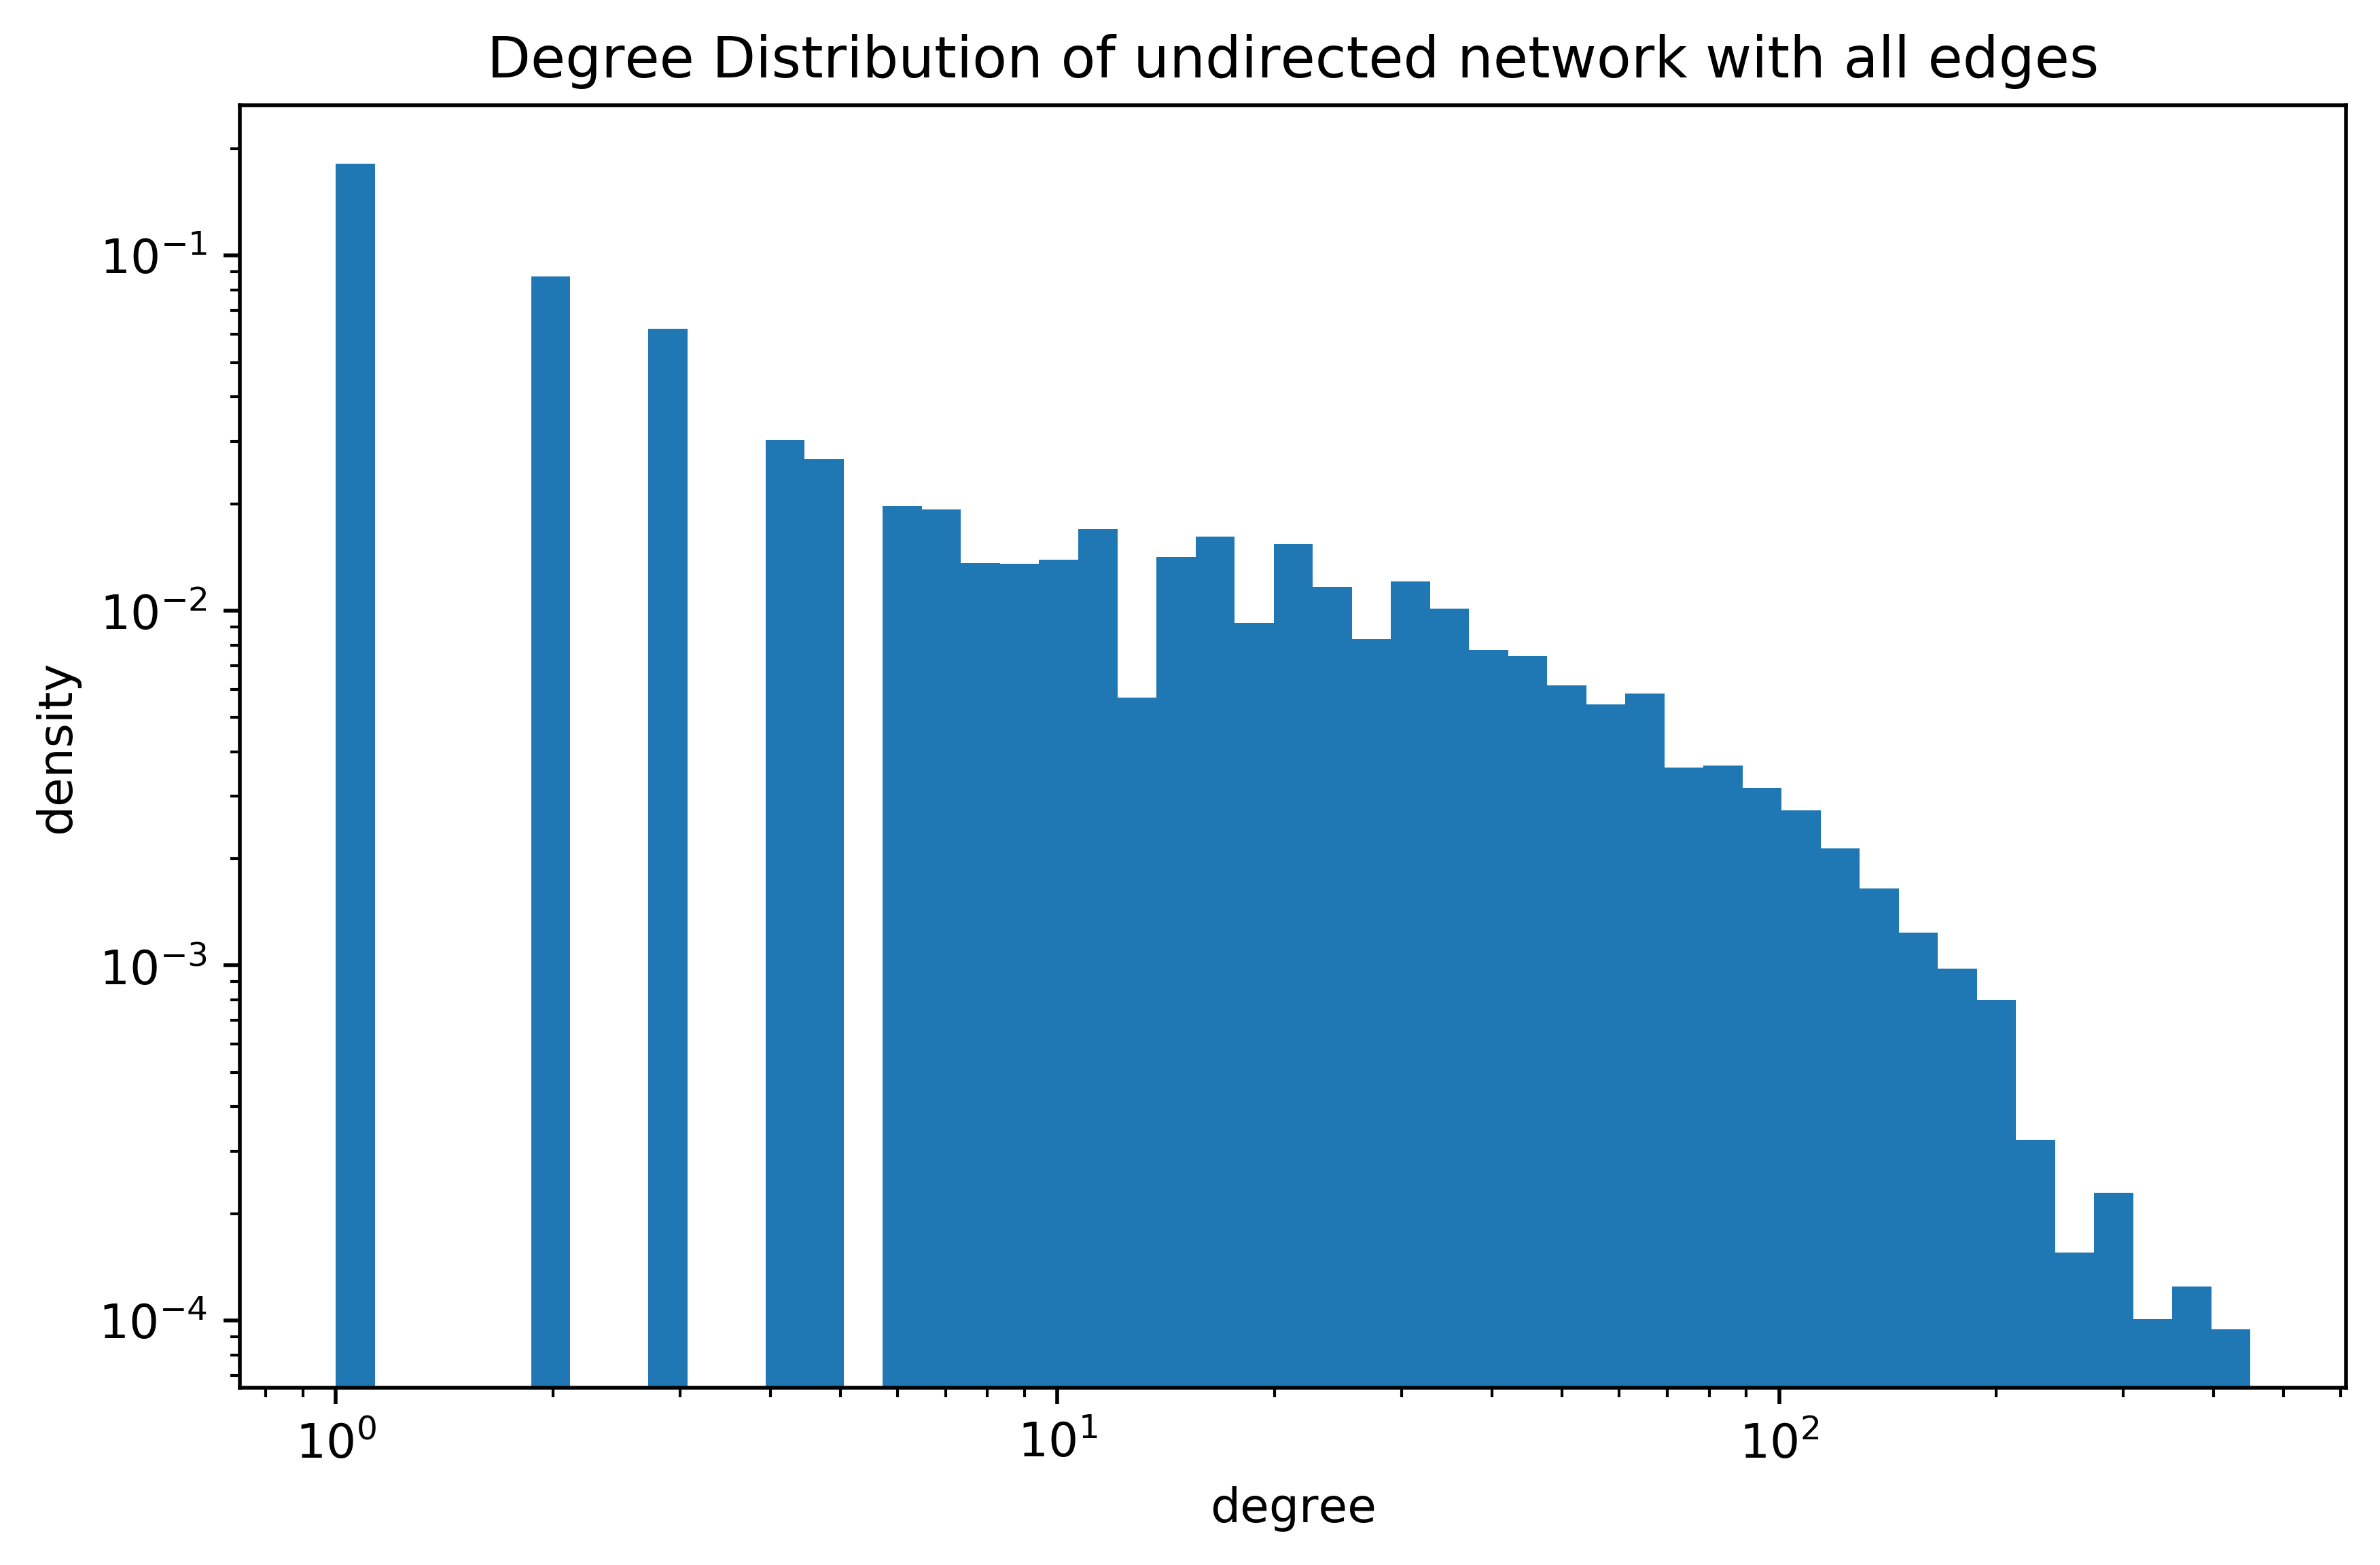

In [10]:
# degree distribution of network
plt.figure(figsize=(8, 5), dpi = 500)
degrees = g.degree()
degrees_list = [ degrees[i] for i in g.nodes()]
log_bin = np.logspace(np.log10(min(degrees_list)+1),np.log10(max(degrees_list)), 50)
plt.hist(degrees_list, bins = log_bin, density = True)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('degree')
plt.ylabel('density')
plt.title("Degree Distribution of undirected network with all edges")
plt.show()

## Create Partitions of Metadata

In [6]:
# get dictionary with node attributes
attr_party = nx.get_node_attributes(g, 'party_short')
attr_gender = nx.get_node_attributes(g, 'gender')
attr_canton = nx.get_node_attributes(g, 'canton')
attr_incumbent = nx.get_node_attributes(g, 'incumbent')
attr_year = nx.get_node_attributes(g, 'year_of_birth')

# Binning the ages into the age groups
attr_age = [year for year in attr_year.values()]
# min 19, max 75

attr_age_group = []
for i in range(len(attr_age)):
  if (attr_age[i] <= 1945):
    group = 0
  elif (attr_age[i] > 1945 and attr_age[i] <= 1964):
    group = 1
  elif (attr_age[i] > 1964 and attr_age[i] <= 1976):
    group = 2
  elif (attr_age[i] > 1976 and attr_age[i] <= 1995):
    group = 3
  else:
    group = 4
  attr_age_group.append(group)

indices_age = np.array(attr_age_group, dtype = "int64")

# change dictionary values to vectors of integers
  # party
values_party = np.array(list(attr_party.values()))
vals_party, indices_party = np.unique(values_party, return_inverse=True)
indices_party = np.array(indices_party, dtype = "int64")

  # gender
values_gender = np.array(list(attr_gender.values()))
vals_gender, indices_gender = np.unique(values_gender, return_inverse=True)
indices_gender = np.array(indices_gender, dtype = "int64")

  # canton
values_canton = np.array(list(attr_canton.values()))
vals_canton, indices_canton = np.unique(values_canton, return_inverse=True)
indices_canton = np.array(indices_canton, dtype = "int64")

  # incumbent
values_incumbent = np.array(list(attr_incumbent.values()))
vals_incumbent, indices_incumbent = np.unique(values_incumbent, return_inverse=True)
indices_incumbent = np.array(indices_incumbent, dtype = "int64")

# Create an array of attributes
polit_attributes = [indices_age, indices_party, indices_incumbent, indices_gender, indices_canton]

# Prepare arrays for p-values
p_values = np.zeros(5, dtype=np.float64)
sd_values = np.zeros(5, dtype=np.float64)

In [7]:
# Calculations
for i, attribute in enumerate(polit_attributes):
  p_values[i], sd_values[i] = BESTest_confidence(polit, attribute, N=100, n_conf=3) # remove the N and n_conf for the full calculations

/Users/natalia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/Users/natalia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


In [8]:
# Print results for all of them
print("All edges")
for i in range(len(polit_attributes)):
  print("p-value: " + str(p_values[i]) + "; " + str(sd_values[i]) + ";")

All edges
p-value: 0.94; 0.008164965809277223;
p-value: 1.0; 0.0;
p-value: 0.9066666666666667; 0.026246692913372727;
p-value: 0.9066666666666667; 0.018856180831641284;
p-value: 0.8933333333333334; 0.009428090415820642;


In [9]:
# Save the results
save_obj(p_values, "out/p_values_all")
save_obj(sd_values, "out/sd_values_all")